This notebook is simulating a real gas and then using SINDy to indentify the governing equation between pressure, temp, volum

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from idealGasSim import molecular_sim, find_earliest_collision
from idealGasSim import update_positions

This is a small visualization of the simulatio of real gas to make sure it's working correctly

In [10]:
box_size = 50

# Number of particles
num_particles = 4
particle_radius = 1.0  # Radius of the particles
large_num = 1000  # A large number for no collision

# Time parameters
t_max = 100 # Total simulation time
dt = 0.1   

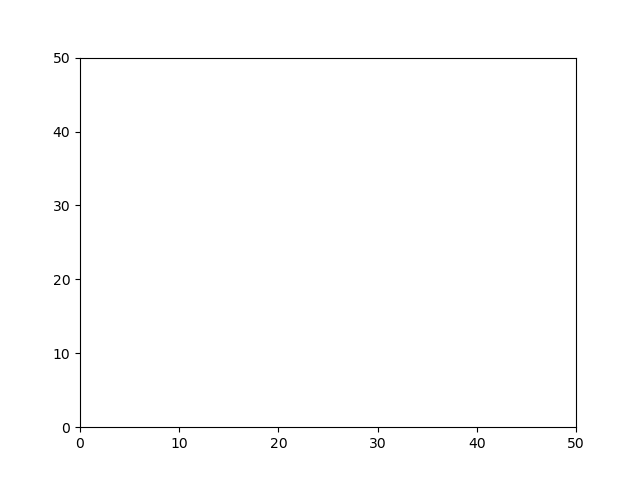

In [12]:
%matplotlib ipympl


# Initialize positions and velocities
np.random.seed(0)  # For reproducibility
positions = np.array([[10.0, 20.0],[13, 20.0],[37, 20.0],[43.0, 20]])
velocities = np.array([[1.5, 0],[1.5, 0],[-1.5, 0.0],[-1.5, 0.0]])

#Visualization setup
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
particles, = ax.plot([], [], 'bo', ms=10)

def init():
    particles.set_data([], [])
    return particles,

def animate(frame):
    global positions, velocities, dt, pressure
    
    # Find the earliest collision
    delta_t, collision_pair = find_earliest_collision(positions, velocities,
                                                      num_particles,
                                                      large_num,
                                                      box_size,
                                                      particle_radius)
    
    # Update positions to the collision time
    if delta_t < dt:
        delta_t += 0.000001
        pressure, positions, velocities = update_positions(positions, velocities, delta_t, collision_pair, pressure,
                                               box_size, num_particles, particle_radius)
        dt -= (delta_t + 0.000001)
    else:
        pressure, positions, velocities = update_positions(positions, velocities, dt, collision_pair, pressure,
                                               box_size,num_particles,particle_radius)
        dt = 0.1  # Reset time step after each update
    
    particles.set_data(positions[:, 0], positions[:, 1])
    return particles,

# Animation
ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
                              interval=20, blit=True, repeat=False)

plt.show()




The idea is that ideal gas law: 

$$P = \frac{RT}{v}$$

does not apply when size of the molecules is not negligible compared to the volum of the container.

van der Waals equation describes the behaviour of real gases:

$$P = \frac{RT}{v - b} - \frac{a}{v^2}$$

where $a$, $b$ are experimentally determinable, substance-specific constants.

As a small experiment, we consider a two cases where the volum of gas molecules is not negligible compared to the box volum (since we are considering a 2D case, we are actually concerned about area). We consider a case where box area is $v_1 = v$ and when it is $v_2 = 2.25v$ and temp is the same in both experiments. In ideal gas scenario: $P_2 = \frac{P_1}{2.25}$

In [28]:
# Number of particles
num_particles = 200
particle_radius = 2.0  # Radius of the particles
large_num = 1000 # A large number for no collision
epsilon = 1e-5  # Small threshold to avoid repeated collisions

# Time parameters
t_max = 1500 # Total simulation time
box_dims = np.arange(1000, 2000, 500)
volum = box_dims**2
all_press = []
np.random.seed(0)  # For reproducibility
positions = np.random.rand(num_particles, 2) * (box_dims[0] - 2 * particle_radius) + particle_radius
velocities = (np.random.rand(num_particles, 2) - 0.5) * 15
# velocities *= 0.1
vs = np.linalg.norm(velocities, axis=1)**2
temp = np.mean(vs)
for box_dim in box_dims:
    
    pressure = molecular_sim(box_dim, num_particles, particle_radius, t_max, large_num, positions, velocities)
    pressure = pressure / t_max
    all_press.append(pressure)
print(all_press)

[7.978348582701336, 5.246362058992955]


In [31]:
print(f'for box dim:{box_dims[0]}, volum:{volum[0]}, and tempareture:{temp}, pressure is:{all_press[0]}')
print(f'for box dim:{box_dims[1]}, volum:{volum[1]}, and tempareture:{temp}, pressure is:{all_press[1]}')

for box dim:1000, volum:1000000, and tempareture:39.372669604080414, pressure is:7.978348582701336
for box dim:1500, volum:2250000, and tempareture:39.372669604080414, pressure is:5.246362058992955


In [34]:
print(f'p_2: {all_press[1]} != p_1/2.25: {all_press[0]/2.25}')

p_2: 5.246362058992955 != p_1/2.25: 3.5459327034228156


next cell uses a bigger set up with different temp, volum to create data for system identification phase

In [32]:

v_multipliers = np.arange(1.0, 2.0, 3.5)
# v_multipliers = np.ones((50, 1))

temps = []
num_particles = 225
particle_radius = 2.0  # Radius of the particles
large_num = 1000 # A large number for no collision
epsilon = 1e-5  # Small threshold to avoid repeated collisions
particle_per_dim = 15
# Time parameters
t_max = 1000 # Total simulation time
box_dims = np.arange(400, 1100, 200)
volum = box_dims**2
all_press = []
for box_dim in box_dims:
    for multiplier in v_multipliers:
        
        np.random.seed(0)
        xs = np.linspace(particle_radius+0.1, box_dim-particle_radius-0.1, particle_per_dim, endpoint=False)
        positions = []
        for i in xs:
            for j in xs:
                positions.append([i,j])
        positions = np.array(positions)
        velocities = (np.random.rand(num_particles, 2) - 0.5) * 10
        velocities *= multiplier
        vs = np.linalg.norm(velocities, axis=1)**2
        temp = np.mean(vs)
        temps.append(temp)
        pressure = molecular_sim(box_dim, num_particles, particle_radius, t_max, large_num, positions, velocities)
        pressure = pressure / t_max
        all_press.append(pressure)
np.savetxt('pressure.csv', all_press, delimiter=',')
np.savetxt('volum.csv', volum, delimiter=',')
np.savetxt('temp.csv', temps, delimiter=',')

In [35]:
all_press = np.genfromtxt('pressure.csv', delimiter=',')
volum = np.genfromtxt('volum.csv', delimiter=',')
temp = np.genfromtxt('temp.csv', delimiter=',')

In [36]:
print(f'len of v is {len(volum)}, and len of press:{len(all_press)}, len of temp:{len(temp)}')

len of v is 15, and len of press:120, len of temp:120


In [37]:
volums = []
for v in volum:
    tmp = [v for i in range(len(all_press)//len(volum))]
    volums += tmp
len(volums)
volum = np.array(volums)

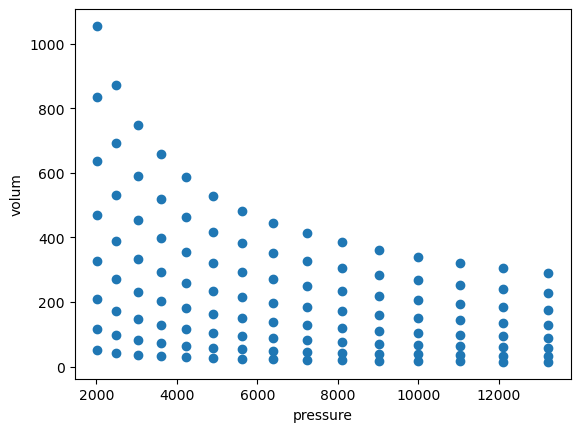

In [38]:

fig = plt.Figure()
plt.scatter(volum, all_press)
plt.xlabel("pressure")
plt.ylabel('volum')
plt.show()

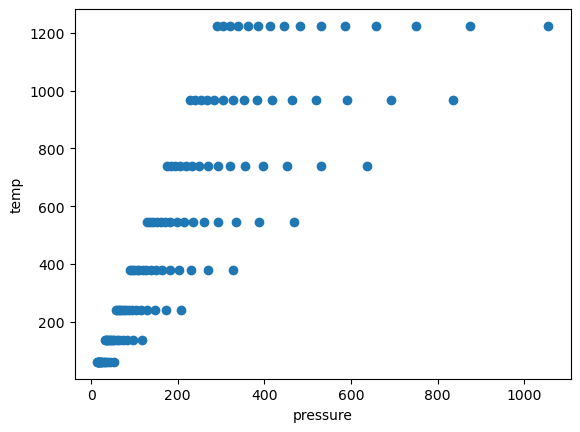

In [39]:
plt.figure()
plt.scatter(all_press, temp)
plt.xlabel("pressure")
plt.ylabel("temp")
plt.show()

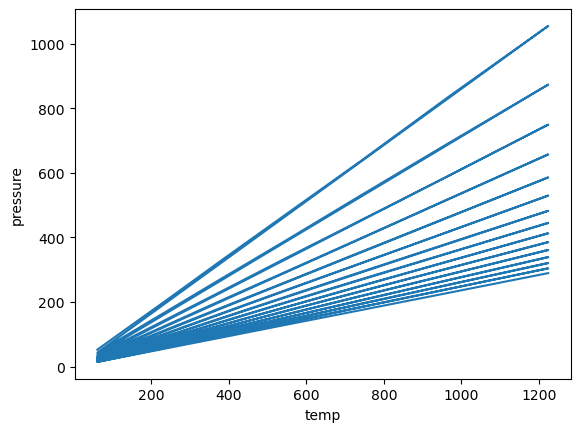

In [40]:
plt.figure()
plt.plot(temp, all_press)
plt.xlabel("temp")
plt.ylabel("pressure")
plt.show()

In [41]:
# Volum
import scipy as sc
argans_radius = 0.1 * 1e-9
vol_change_rate = argans_radius / particle_radius
# So now my dim in these terms is: new_dim = dim * vol_change_rate
V = volum * vol_change_rate**2
sim_n = 500
N_A = sc.constants.Avogadro # Avogadro constant
N = num_particles # The number of molecules
molar_v = (V * N_A / N)
# molar_v = molar_v / 1000.0

R = sc.constants.R   # universtal gas constant
b = 4 * (sc.constants.pi * (argans_radius)**2) * N_A

a = 50
T = temp # Temp
# p_ideal = (sc.constants.R * T) / molar_v
# print(f'p ideal is {p_ideal} and measured pressure is {pressure}')
# p_vdw = ((sc.constants.R * T) / (molar_v - b)) - (a / (molar_v**2))
# p_vdw_noisy = p_vdw + np.random.normal(0, 0.6, len(p_vdw))
# input = {'molar_v': molar_v, 'T': T}

In [45]:
input = {'molar_v': molar_v, 'T': T}


In [46]:
from scipy.optimize import curve_fit
def idealGas(input, a_):
    return a_ * input['T'] / input['molar_v']

def vdw(input, a_, b_, c_):
    return ((a_ * input['T']) / (input['molar_v'] - b_)) + (c_ / (input['molar_v']**2))

def linear(input, a_, b_):
    return a_ * input['T'] + b_ * input['molar_v']

def cube(input, a_, b_, c_, d_, e_, f_):
    return (a_ * input['T'] + f_) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2) + e_ / (input['molar_v']**3)

def fract(input, a_, b_, c_, d_, e_):
    return (a_ * input['molar_v']) / (d_ * input['T'] - b_) + c_ / (input['molar_v']**2) + e_ * input['T']

def vdw_linearT(input, a_, b_, c_, d_, e_):
    return (a_ * input['T']) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2) + e_ * input['T']


def vdw_linearT2(input, a_, b_, c_, d_):
    return (a_ * input['T']) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2)

def vdw_linearT3(input, a_, b_, c_, d_, e_):
    return (a_ * input['T']) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2) + e_ * input['molar_v']

def idealGas2(input, a_, b_):
    return a_ * input['T'] / input['molar_v'] + b_ * input['T']

def idealGas3(input, a_, b_, d_):
    return (a_ * input['T'] + d_) / input['molar_v'] + b_ * input['T']

func_dict = {'idealGas' : (idealGas, 1),
             'vdw' : (vdw, 3),
             'linear' : (linear, 2),
             'fract' : (fract, 5),
             'ideaGas2' : (idealGas2, 2),
             'idealGas3' : (idealGas3, 3),
             'vdw_linearT': (vdw_linearT, 5),
             'vdw_linearT2': (vdw_linearT2, 4),
             'vdw_linearT3': (vdw_linearT3, 5)}


In [47]:
loss = np.inf
chosen = ''
lam = 0.0
popt_save = 0
sim_n = len(all_press)

for key in func_dict:
    f, n_param = func_dict[key]
    p0 = [sc.constants.R]
    for i in range(n_param-1):
        p0.append(1)
    popt, pcov = curve_fit(f, input, all_press, method='lm')

    e = all_press - f(input, *popt)
    tmp_loss = np.sum(e**2)/sim_n + lam * n_param
    print(f'for {key}, the param is \n {popt} \n and loss is {tmp_loss}')
    if tmp_loss < loss:
        loss = tmp_loss
        print(tmp_loss)
        print(key)
        chosen = key
        popt_save = popt

for idealGas, the param is 
 [14656.46213788] 
 and loss is 2000.6675498527932
2000.6675498527932
idealGas
for vdw, the param is 
 [2.03627797e+02 1.85381929e+04 1.00000041e+00] 
 and loss is 77346.87561644755
for linear, the param is 
 [ 0.51235485 -0.00138963] 
 and loss is 10968.953297781956
for fract, the param is 
 [-4.03188128e+01 -2.69295732e+04  1.00000000e+00 -1.68740516e+01
  6.65426154e-01] 
 and loss is 5588.990546837074
for ideaGas2, the param is 
 [1.10875896e+04 1.29876278e-01] 
 and loss is 4.91240589104694
4.91240589104694
ideaGas2
for idealGas3, the param is 
 [1.10865123e+04 1.29876278e-01 8.79012343e+02] 
 and loss is 4.912150722983435
4.912150722983435
idealGas3


/tmp/ipykernel_23318/1752823443.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f, input, all_press, method='lm')


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.